# 1.0 An end-to-end classification problem (Testing)



## 1.1 Dataset description

The notebooks focus on a borrower's **credit modeling problem**. The database was downloaded through a dataquest project and is available at link below. The data is from **Lending Club** and contains data from loans made in the period **2007 to 2011**. Lending Club is a marketplace for personal loans that matches borrowers who are seeking a loan with investors looking to lend money and make a return. The **target variable**, or what we are wanting to predict, is whether or not, given a person's history, they will repay the loan.

You can download the data from the [Kaggle](https://www.kaggle.com/datasets/samaxtech/lending-club-20072011-data).

Let's take the following steps:

1. ETL (done)
2. Data Checks (done)
3. Data Segregation (done)
4. Training (done)
5. Test

<center><img width="600" src="https://drive.google.com/uc?export=view&id=1fKGuR5U5ECf7On6Zo1UWzAIWZrMmZnGc"></center>

## 1.2 Install, load libraries

In [3]:
import logging
import pandas as pd
import wandb
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
# Login to Weights & Biases
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hangtn13-ssc-national-economics-university (use `wandb login --relogin` to force relogin)


True

## 1.3 Test evaluation

### 1.3.1 Definition of the base classes

This is necessary in order to ```joblib.load()```see the previous definitions used in the Train Pipeline.

In [5]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip() if row.dtype == "object" else row)

        if self.new_features:
            # Define mappings
            mapping_dict = {
                'basic 4y': 4,
                'basic 6y': 6,
                'basic 9y': 9,
                'high school': 12,
                'professional course': 19,
                'university degree': 16,
                'illiterate': 0,
                'unknown': -1
            }

            month_map = {
                'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
                'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
                'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
            }

            weekday_map = {
                'mon': 1, 'tue': 2, 'wed': 3,
                'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7
            }

            if 'education' in df.columns:
                df['education'] = df['education'].replace(mapping_dict)

            if 'month' in df.columns:
                df['month'] = df['month'].replace(month_map)

            if 'day_of_week' in df.columns:
                df['day_of_week'] = df['day_of_week'].replace(weekday_map)

        self.colnames = df.columns
        return df


# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

### 1.3.2 Evaluation

In [1]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = "Bank-Marketing/test.csv:latest"

# name of the model artifact
artifact_model_name = "Bank-Marketing/model_export:latest"

# name of the target encoder artifact
artifact_encoder_name = "Bank-Marketing/target_encoder:latest"

In [6]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

In [15]:
# initiate the wandb project
run = wandb.init(project="Bank-Marketing",job_type="test")

Acc,0.80193
F1,0.43829
Precision,0.3276
ROC-AUC,0.74119
Recall,0.66196


In [16]:
import os

In [17]:
logger.info("Downloading and reading test artifact")
artifact = run.use_artifact(artifact_test_name)
artifact_dir = artifact.download()

# Now access the file directly
test_data_path = os.path.join(artifact_dir, "test.csv")
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("y")

08-05-2025 22:27:39 Downloading and reading test artifact
08-05-2025 22:27:41 Extracting target from dataframe


In [18]:
# Takes a look at test set
x_test.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,pdays_contacted_status
0,51,self-employed,married,university degree,unknown,no,no,telephone,jun,fri,2,NaN,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,0
1,40,technician,single,high school,no,yes,no,cellular,aug,fri,1,NaN,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,0
2,34,admin,married,university degree,no,no,no,cellular,jul,wed,2,NaN,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,0
3,38,blue-collar,married,basic 9y,no,no,no,telephone,may,tue,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,31,blue-collar,married,basic 6y,no,no,no,cellular,may,tue,3,NaN,1,failure,-1.8,92.893,-46.2,1.291,5099.1,0


In [19]:
# Take a look at the target variable
y_test.head()

0     no
1     no
2    yes
3     no
4     no
Name: y, dtype: object

In [20]:
# Extract the encoding of the target variable
logger.info("Extracting the encoding of the target variable")
artifact = run.use_artifact(artifact_encoder_name)
artifact_dir = artifact.download()  # downloads the artifact contents to a local directory

encoder_path = os.path.join(artifact_dir, "target_encoder")  # update if the file has a different name
le = joblib.load(encoder_path)

08-05-2025 22:27:43 Extracting the encoding of the target variable


In [21]:
# transform y_train
y_test = le.transform(y_test)
logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

08-05-2025 22:27:46 Classes [0, 1]: ['no' 'yes']


In [22]:
# target variable after the encoding
y_test

array([0, 0, 1, ..., 0, 0, 1])

In [23]:
# Download inference artifact
logger.info("Downloading and load the exported model")
model_artifact = run.use_artifact(artifact_model_name)
artifact_dir = model_artifact.download()
# Inspect files in the artifact directory
import os
for root, dirs, files in os.walk(artifact_dir):
    for file in files:
        print(os.path.join(root, file))  # This will help you find the correct filename
model_path = os.path.join(artifact_dir, "model_export")  # update if the file has a different name
pipe = joblib.load(model_path)

08-05-2025 22:27:46 Downloading and load the exported model


.\artifacts\model_export-v7\model_export


In [24]:
# predict
logger.info("Infering")
predict = pipe.predict(x_test)

# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(y_test, predict, beta=1, zero_division=1)
precision = precision_score(y_test, predict, zero_division=1)
recall = recall_score(y_test, predict, zero_division=1)
acc = accuracy_score(y_test, predict)
roc_auc = roc_auc_score(y_test, predict)

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))
logger.info("Test ROC-AUC:{}".format(roc_auc))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
run.summary["ROC-AUC"] = roc_auc

08-05-2025 22:27:48 Infering
c:\Users\dell\miniconda3\envs\bankmkt\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
08-05-2025 22:27:49 Test Evaluation metrics
08-05-2025 22:27:49 Test Accuracy: 0.7755360994797614
08-05-2025 22:27:49 Test Precision: 0.29891046897205115
08-05-2025 22:27:49 Test Recall: 0.6858695652173913
08-05-2025 22:27:49 Test F1: 0.4163642362256681
08-05-2025 22:27:49 Test ROC-AUC:0.7366282174600102


In [25]:
x_test

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,pdays_contacted_status
0,51,self-employed,married,university degree,unknown,no,no,telephone,jun,fri,2,NaN,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,0
1,40,technician,single,high school,no,yes,no,cellular,aug,fri,1,NaN,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,0
2,34,admin,married,university degree,no,no,no,cellular,jul,wed,2,NaN,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,0
3,38,blue-collar,married,basic 9y,no,no,no,telephone,may,tue,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,31,blue-collar,married,basic 6y,no,no,no,cellular,may,tue,3,NaN,1,failure,-1.8,92.893,-46.2,1.291,5099.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7876,46,technician,married,high school,no,unknown,unknown,telephone,jun,mon,1,NaN,0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0
7877,42,self-employed,married,unknown,no,yes,no,telephone,jun,tue,3,NaN,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,0
7878,45,services,divorced,basic 9y,no,no,no,cellular,apr,mon,1,NaN,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
7879,42,technician,divorced,high school,no,no,no,telephone,may,tue,4,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [26]:
person1 = pd.DataFrame([[25.0, 'doctor', 'married', 'unknown', 'no', 'no', 'no', 'cellular','nov', 'mon',
                         1.0, 6.0, 0.0, 'nonexistent', -3.4, 92.649, -30.1, 0.714, 5017.5, 0.0]], columns=x_test.columns)
person1

SyntaxError: invalid syntax (3998889376.py, line 1)

In [ ]:
predict = pipe.predict(person1)
predict[0]

[LightGBM] [Warning] Unknown parameter: class_weight_0
[LightGBM] [Warning] Unknown parameter: class_weight_1
[LightGBM] [Warning] feature_fraction is set=0.41903934093830536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41903934093830536
[LightGBM] [Warning] bagging_fraction is set=0.40251337723690406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40251337723690406
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


c:\Users\dell\miniconda3\envs\bankmkt\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


1

In [ ]:
person2 = pd.DataFrame([[36.0, 'teacher', 'married', 'unknown', 'no', 'no', 'no', 'laptop', 'nov', 'mon',
                         1.0, 6.0, 0.0, 'nonexistent', -3.4, 92.649, -30.1, 0.714, 5017.5, 0.0]], columns=x_test.columns)
person2

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,pdays_contacted_status
0,36.0,teacher,married,unknown,no,no,no,laptop,nov,mon,1.0,6.0,0.0,nonexistent,-3.4,92.649,-30.1,0.714,5017.5,0.0


In [ ]:
print(pipe.predict(person2))

[LightGBM] [Warning] Unknown parameter: class_weight_0
[LightGBM] [Warning] Unknown parameter: class_weight_1
[LightGBM] [Warning] feature_fraction is set=0.41903934093830536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41903934093830536
[LightGBM] [Warning] bagging_fraction is set=0.40251337723690406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40251337723690406
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[1]


c:\Users\dell\miniconda3\envs\bankmkt\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [0, 6, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# Compare the accuracy, precision, recall with previous ones
from sklearn.metrics import classification_report

# Correct way
y_pred = pipe.predict(x_test)  # Predict on the entire test set
print(classification_report(y_test, y_pred))

c:\Users\dell\miniconda3\envs\bankmkt\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: class_weight_0
[LightGBM] [Warning] Unknown parameter: class_weight_1
[LightGBM] [Warning] feature_fraction is set=0.41903934093830536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41903934093830536
[LightGBM] [Warning] bagging_fraction is set=0.40251337723690406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40251337723690406
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      6961
           1       0.30      0.68      0.42       920

    accuracy                           0.78      7881
   macro avg       0.62      0.74      0.64      7881
weighted avg       0.87      0.78      0.81      7881



Text(0, 0.5, 'Predicted Label')

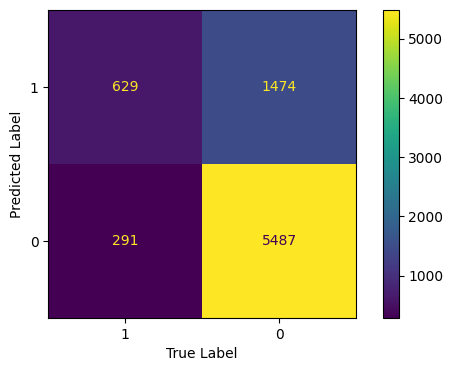

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Generate the confusion matrix
cm = confusion_matrix(y_pred, y_test, labels=[1, 0])

# Plot the confusion matrix
fig_confusion_matrix, ax = plt.subplots(1, 1, figsize=(7, 4))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1", "0"]).plot(values_format=".0f", ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")


In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

08-05-2025 22:19:46 Uploading figures


In [ ]:
run.finish()

Acc,0.77604
F1,0.41614
Precision,0.2991
ROC-AUC,0.73597
Recall,0.6837
